## Benchmark Result

In [1]:
# Import Object from result.json
import json

with open('result.json') as f:
    data = json.load(f)

print(data[:1])

[{'nodes': 4, 'max_edge_weight': 7, 'avg_edge_weight': 3.0, 'distance_matrix': [[0, 6, 5, 1], [6, 0, 3, 2], [5, 3, 0, 7], [1, 2, 7, 0]], 'constraint_weight': 1000000, 'time_model_formulation': 0.0203249454498291, 'solvers_results': [{'name': 'Fixstars 1s', 'objective': 11.0, 'execution_time': 0.038015, 'total_time': 2.8731420040130615}, {'name': 'Fixstars 10s', 'objective': 11.0, 'execution_time': 0.037598, 'total_time': 11.854793071746826}, {'name': 'DWave 4.1', 'objective': 11.0, 'execution_time': 0.190522, 'total_time': 8.018798112869263}, {'name': 'DWave 6.4', 'objective': 11.0, 'execution_time': 0.094442, 'total_time': 3.6663107872009277}, {'name': 'Brute Force', 'objective': 11, 'execution_time': 1.5020370483398438e-05, 'total_time': 1.5020370483398438e-05}, {'name': 'Gurobi 10s', 'objective': 11.0, 'execution_time': 0.013116, 'total_time': 0.03666090965270996}]}]


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

### Success Count by Solver vs $n$

Similar result with previous benchmark.

In [6]:
def name_change(solver):
    if solver == "DWave 4.1":
        return "D-Wave AS4.1"
    elif solver == "DWave 6.4":
        return "D-Wave AS6.4"
    else:
        return solver

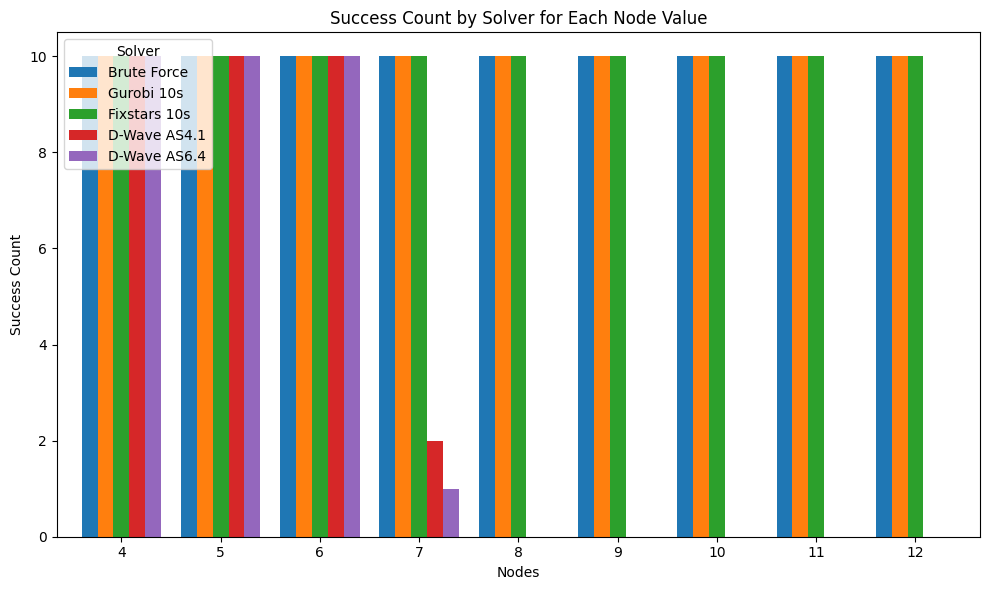

In [7]:
# Prepare data for plotting
records = []
for item in data:
    nodes = item["nodes"]
    for solver in item["solvers_results"]:
        success = solver["objective"] is not None and solver["execution_time"] is not None
        records.append({"nodes": nodes, "solver": name_change(solver["name"]), "success": int(success)})

# Convert to DataFrame
df = pd.DataFrame(records)

# Group by nodes and solver to count successes
success_counts = df.groupby(["nodes", "solver"]).sum().reset_index()

# Pivot data for plotting
pivot_data = success_counts.pivot(index="nodes", columns="solver", values="success").fillna(0)

# Ensure legend order
solver_order = ["Brute Force", "Gurobi 10s", "Fixstars 10s", "D-Wave AS4.1", "D-Wave AS6.4"]
pivot_data = pivot_data[solver_order]

# Plot multi-bar chart
pivot_data.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title("Success Count by Solver for Each Node Value")
plt.xlabel("Nodes")
plt.ylabel("Success Count")
plt.legend(title="Solver", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Box and Whisker Plot of Execution Time vs Nodes

No difference from previous benchmark.

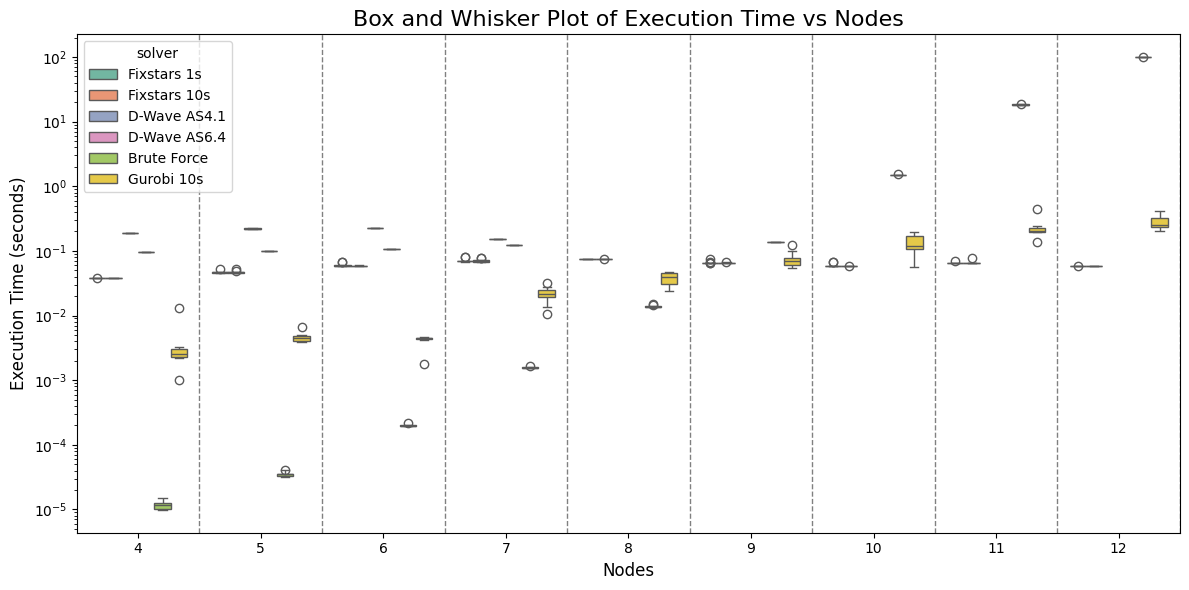

In [8]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    for result in dataset["solvers_results"]:
        plot_data.append({
            "nodes": dataset["nodes"],
            "solver": name_change(result["name"]),
            "execution_time": result["execution_time"]
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for execution_time vs nodes
plt.figure(figsize=(12, 6))
sns.boxplot(x="nodes", y="execution_time", hue="solver", data=df_plot, palette="Set2")

# Add title and labels
plt.title('Box and Whisker Plot of Execution Time vs Nodes', fontsize=16)
plt.xlabel('Nodes', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)

# Add vertical lines as guidelines to separate each "nodes" group
nodes = df_plot['nodes'].unique()
for node in nodes:
    plt.axvline(x=list(nodes).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

plt.yscale("log")

# Show the plot
plt.tight_layout()
plt.show()

### Linear Plot of Execution Time for Fixstars and D-Wave

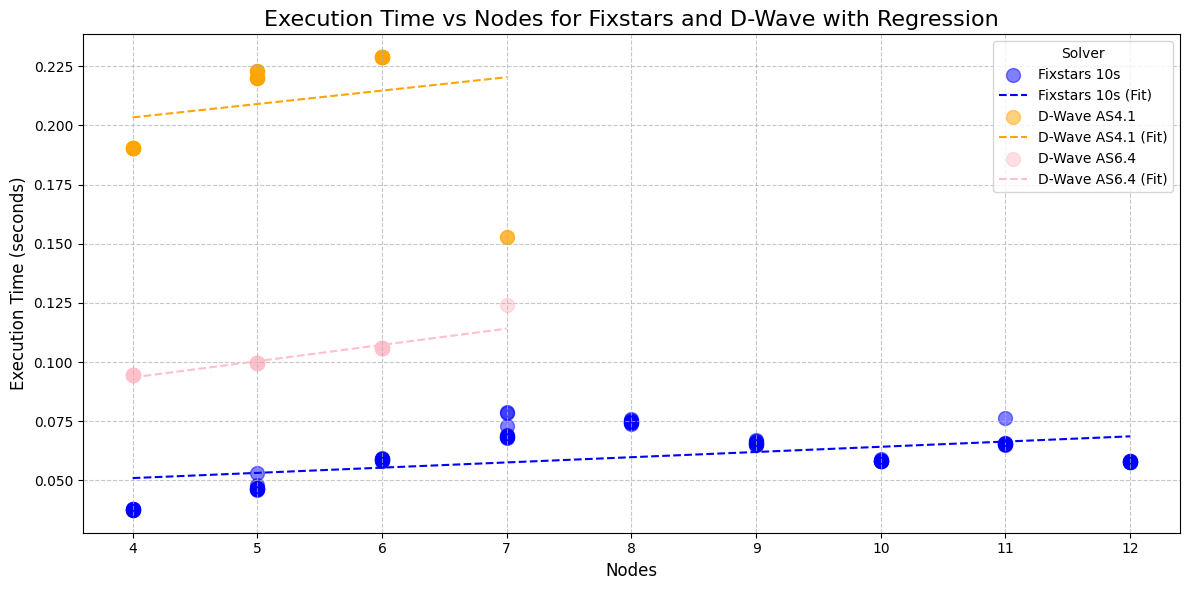

In [10]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    nodes = dataset["nodes"]
    for result in dataset["solvers_results"]:
        if result["execution_time"] is not None:  # Include only valid execution times
            plot_data.append({
                "nodes": nodes,
                "solver": name_change(result["name"]),
                "execution_time": result["execution_time"]
            })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Filter data for Fixstars and D-Wave
fixstars1s_data = df_plot[df_plot["solver"] == "Fixstars 1s"]
fixstars10s_data = df_plot[df_plot["solver"] == "Fixstars 10s"]
dwave41_data = df_plot[df_plot["solver"] == "D-Wave AS4.1"]
dwave64_data = df_plot[df_plot["solver"] == "D-Wave AS6.4"]

# Function to perform linear regression and get line points
def add_regression_line(x, y, ax, label, color):
    # Reshape data for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y)
    
    # Predict y values for regression line
    x_line = np.linspace(min(x), max(x), 100)
    y_line = model.predict(x_line.reshape(-1, 1))
    
    # Plot the regression line
    ax.plot(x_line, y_line, label=f"{label} (Fit)", color=color, linestyle='--')

# Create scatter plot with regression lines
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot scatter for Fixstars with opacity
# plt.scatter(fixstars1s_data["nodes"], fixstars1s_data["execution_time"], label="Fixstars 1s", color="blue", s=100, alpha=0.5)
# add_regression_line(fixstars1s_data["nodes"], fixstars1s_data["execution_time"], ax, "Fixstars 1s", "blue")
plt.scatter(fixstars10s_data["nodes"], fixstars10s_data["execution_time"], label="Fixstars 10s", color="blue", s=100, alpha=0.5)
add_regression_line(fixstars10s_data["nodes"], fixstars10s_data["execution_time"], ax, "Fixstars 10s", "blue")

# Plot scatter for D-Wave with opacity
plt.scatter(dwave41_data["nodes"], dwave41_data["execution_time"], label="D-Wave AS4.1", color="orange", s=100, alpha=0.5)
add_regression_line(dwave41_data["nodes"], dwave41_data["execution_time"], ax, "D-Wave AS4.1", "orange")
plt.scatter(dwave64_data["nodes"], dwave64_data["execution_time"], label="D-Wave AS6.4", color="pink", s=100, alpha=0.5)
add_regression_line(dwave64_data["nodes"], dwave64_data["execution_time"], ax, "D-Wave AS6.4", "pink")
# plt.scatter(dwaveV2_data["nodes"], dwaveV2_data["execution_time"], label="D-Wave V2p2.6", color="red", s=100, alpha=0.5)

# Add labels, legend, and title
plt.title("Execution Time vs Nodes for Fixstars and D-Wave with Regression", fontsize=16)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Execution Time (seconds)", fontsize=12)
plt.legend(title="Solver", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### Linear Plot of Execution Time for D-Wave only

**This graph probably unused**

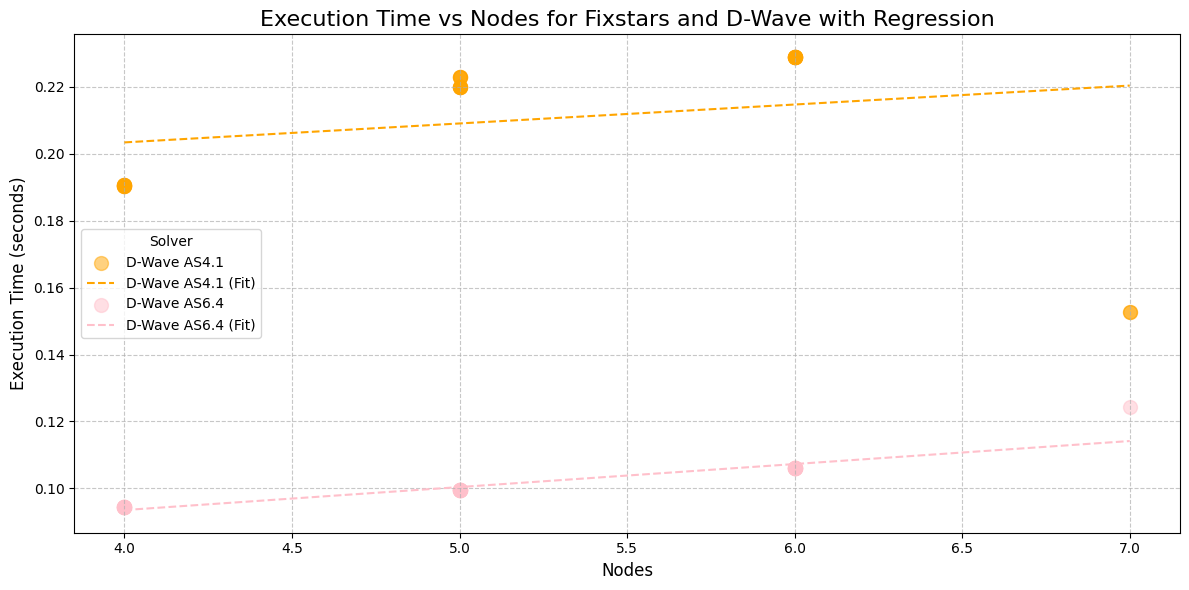

In [12]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    nodes = dataset["nodes"]
    for result in dataset["solvers_results"]:
        if result["execution_time"] is not None:  # Include only valid execution times
            plot_data.append({
                "nodes": nodes,
                "solver": name_change(result["name"]),
                "execution_time": result["execution_time"]
            })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Filter data for Fixstars and D-Wave
# fixstars1s_data = df_plot[df_plot["solver"] == "Fixstars 1s"]
# fixstars10s_data = df_plot[df_plot["solver"] == "Fixstars 10s"]
dwave41_data = df_plot[df_plot["solver"] == "D-Wave AS4.1"]
dwave64_data = df_plot[df_plot["solver"] == "D-Wave AS6.4"]
dwaveV2_data = df_plot[df_plot["solver"] == "D-Wave V2p2.6"]

# Function to perform linear regression and get line points
def add_regression_line(x, y, ax, label, color):
    # Reshape data for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y)
    
    # Predict y values for regression line
    x_line = np.linspace(min(x), max(x), 100)
    y_line = model.predict(x_line.reshape(-1, 1))
    
    # Plot the regression line
    ax.plot(x_line, y_line, label=f"{label} (Fit)", color=color, linestyle='--')

# Create scatter plot with regression lines
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot scatter for Fixstars with opacity
# plt.scatter(fixstars1s_data["nodes"], fixstars1s_data["execution_time"], label="Fixstars 1s", color="blue", s=100, alpha=0.5)
# add_regression_line(fixstars1s_data["nodes"], fixstars1s_data["execution_time"], ax, "Fixstars 1s", "blue")
# plt.scatter(fixstars10s_data["nodes"], fixstars10s_data["execution_time"], label="Fixstars 10s", color="blue", s=100, alpha=0.5)
# add_regression_line(fixstars10s_data["nodes"], fixstars10s_data["execution_time"], ax, "Fixstars 10s", "blue")

# Plot scatter for D-Wave with opacity
plt.scatter(dwave41_data["nodes"], dwave41_data["execution_time"], label="D-Wave AS4.1", color="orange", s=100, alpha=0.5)
add_regression_line(dwave41_data["nodes"], dwave41_data["execution_time"], ax, "D-Wave AS4.1", "orange")
plt.scatter(dwave64_data["nodes"], dwave64_data["execution_time"], label="D-Wave AS6.4", color="pink", s=100, alpha=0.5)
add_regression_line(dwave64_data["nodes"], dwave64_data["execution_time"], ax, "D-Wave AS6.4", "pink")
# plt.scatter(dwaveV2_data["nodes"], dwaveV2_data["execution_time"], label="D-Wave V2p2.6", color="red", s=100, alpha=0.5)
# add_regression_line(dwaveV2_data["nodes"], dwaveV2_data["execution_time"], ax, "D-Wave V2p2.6", "red")

# Add labels, legend, and title
plt.title("Execution Time vs Nodes for Fixstars and D-Wave with Regression", fontsize=16)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Execution Time (seconds)", fontsize=12)
plt.legend(title="Solver", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### Box and Whisker Plot of Objective vs Nodes

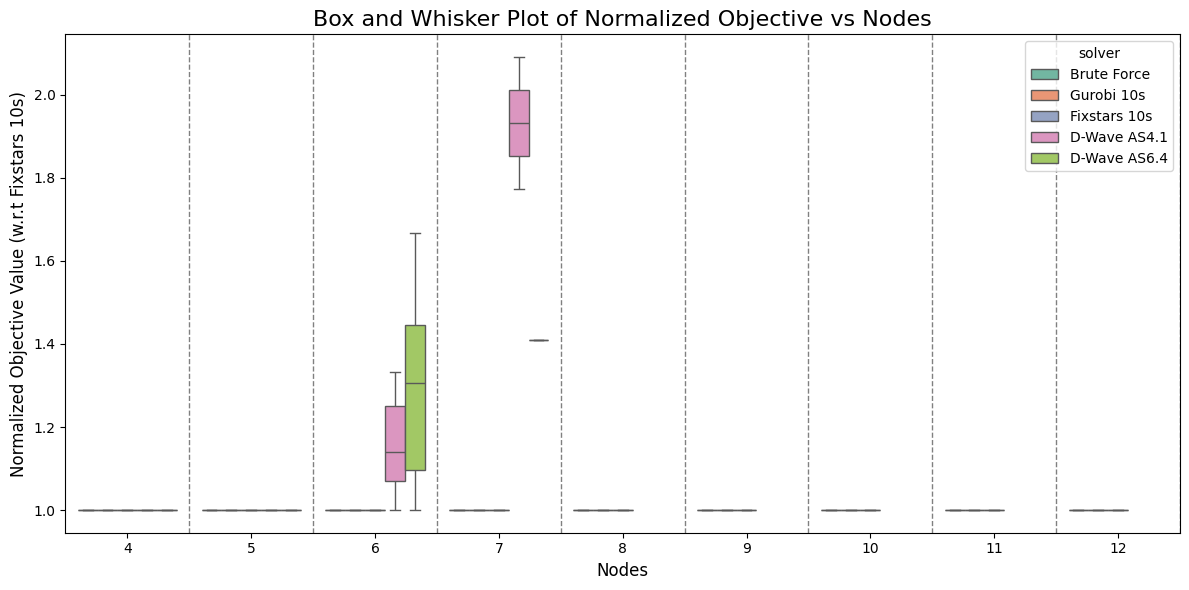

In [13]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    # Extract objective value of Fixstars 10s to normalize others
    fixstars_10s_objective = next(
        result["objective"] for result in dataset["solvers_results"] if result["name"] == "Fixstars 10s"
    )
    
    for result in dataset["solvers_results"]:
        # Skip failed solvers where objective is None
        if result["objective"] is None:
            continue
        
        # Normalize the objective value
        normalized_objective = result["objective"] / fixstars_10s_objective if fixstars_10s_objective != 0 else 0
        plot_data.append({
            "nodes": dataset["nodes"],
            "solver": name_change(result["name"]),
            "normalized_objective": normalized_objective
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for normalized objective vs nodes
plt.figure(figsize=(12, 6))
sns.boxplot(x="nodes", y="normalized_objective", hue="solver", data=df_plot, palette="Set2", hue_order=["Brute Force", "Gurobi 10s", "Fixstars 10s", "D-Wave AS4.1", "D-Wave AS6.4"])

# Add title and labels
plt.title('Box and Whisker Plot of Normalized Objective vs Nodes', fontsize=16)
plt.xlabel('Nodes', fontsize=12)
plt.ylabel('Normalized Objective Value (w.r.t Fixstars 10s)', fontsize=12)

# Add vertical lines as guidelines to separate each "nodes" group
nodes = df_plot['nodes'].unique()
for node in nodes:
    plt.axvline(x=list(nodes).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

# Show the plot
plt.tight_layout()
plt.show()

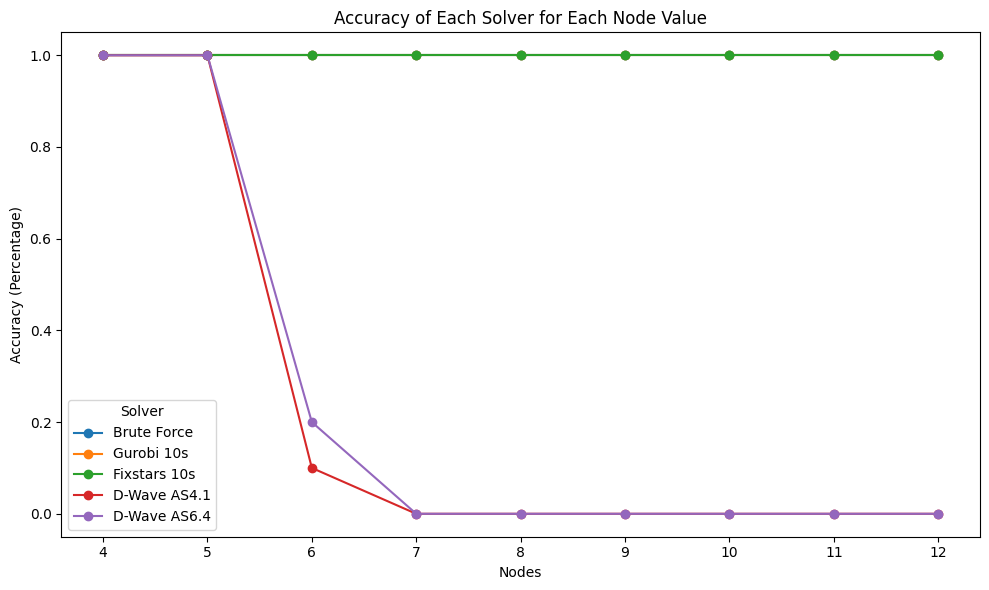

In [14]:
# Prepare data for plotting accuracy
accuracy_data = []
for dataset in data:
    nodes = dataset["nodes"]
    # Find the best objective value for the current dataset
    best_objective = min(
        result["objective"] for result in dataset["solvers_results"] if result["objective"] is not None
    )
    
    for result in dataset["solvers_results"]:
        # Skip failed solvers where objective is None
        if result["objective"] is None:
            continue
        
        # Calculate accuracy
        accuracy = 1 if result["objective"] == best_objective else 0
        accuracy_data.append({
            "nodes": nodes,
            "solver": name_change(result["name"]),
            "accuracy": accuracy
        })

# Convert to DataFrame
df_accuracy = pd.DataFrame(accuracy_data)

# Group by nodes and solver to calculate accuracy percentage
accuracy_counts = df_accuracy.groupby(["nodes", "solver"]).mean().reset_index()

# Pivot data for plotting
pivot_accuracy = accuracy_counts.pivot(index="nodes", columns="solver", values="accuracy").fillna(0)

# Ensure legend order
solver_order = ["Brute Force", "Gurobi 10s", "Fixstars 10s", "D-Wave AS4.1", "D-Wave AS6.4"]
pivot_accuracy = pivot_accuracy[solver_order]

# Plot multi-bar chart for accuracy
pivot_accuracy.plot(kind="line", figsize=(10, 6), marker='o')
plt.title("Accuracy of Each Solver for Each Node Value")
plt.xlabel("Nodes")
plt.ylabel("Accuracy (Percentage)")
plt.legend(title="Solver", loc="lower left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Summary

TODO